In [3]:
import sys
import importlib
sys.path.append(r'../../pykneer')
sys.path.append(r'../pykneer')
import pykneer_io as io
importlib.reload(io)
import preprocessing_for_nb as prep
importlib.reload(prep)
import segmentation_sa_for_nb as segm
importlib.reload(segm)

import SimpleITK as sitk
import matplotlib.pyplot as plt

from preparing_images import prepare_image_and_list

In [20]:
# process list
# first in TP as reference
caselist = [
#     {'pid': '9189303','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'L'},
    {'pid': '9941446','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'L'},
    {'pid': '9941446','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'R'},
    {'pid': '9404954','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'L'},
    {'pid': '9404954','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'R'},
    {'pid': '9939718','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'R'},
    {'pid': '9941231','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'L'},
    {'pid': '9941231','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'R'},
    {'pid': '9942030','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'L'},
    {'pid': '9942030','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'R'},
    {'pid': '9942724','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'L'},
    {'pid': '9942724','TP':[0,1,2,3,4,5,6,8,10],'TP2':[0,12,18,24,30,36,48,72,96],'side':'R'},
]

prepare_image_and_list(caselist)

ahaknee0tp29  exist
dcm path for TPid 0 Z:/OAI Baseline/gc0/9941446/10304807
Loading QVJ Y:/0tp29\cascade/0/9941446/10304807L\E10304807L_L.QVJ
Adding QVS E10304807LS101_L.QVS
coronal Z:/OAI Baseline/gc0/9941446/10304807/001.dcm
ahaknee12tp29  exist
dcm path for TPid 1 Z:/OAI 12 Months/1.C.2/9941446/20051207/10632205
Loading QVJ Y:/12tp29\cascade/12/9941446/20051207L\E20051207L_L.QVJ
Adding QVS E20051207LS101_L.QVS
coronal Z:/OAI 12 Months/1.C.2/9941446/20051207/10632205/001.dcm
no such contour OuterWall
No lumen contour for frappe dcm slice 75
ahaknee18tp29  exist
cannot find dcm path for TPid 2
ahaknee24tp29  exist
dcm path for TPid 3 Z:/OAI 24 Months/3.C.2/9941446/20070111/11492208
Loading QVJ Y:/24tp29\cascade/24/9941446/20070111L\E20070111L_L.QVJ
Adding QVS E20070111LS101_L.QVS
coronal Z:/OAI 24 Months/3.C.2/9941446/20070111/11492208/001.dcm
ahaknee30tp29  exist
cannot find dcm path for TPid 4
ahaknee36tp29  exist
cannot find dcm path for TPid 5
ahaknee48tp29  exist
dcm path for TP

copying Z:/OAI 24 Months/3.C.2/9941231/20060804/11265114/078.dcmno such contour OuterWall
No lumen contour for frappe dcm slice 77
copying Z:/OAI 24 Months/3.C.2/9941231/20060804/11265114/079.dcmno such contour OuterWall
No lumen contour for frappe dcm slice 78
ahaknee30tp29  exist
cannot find dcm path for TPid 4
ahaknee36tp29  exist
dcm path for TPid 5 Z:/OAI 36 Months/5.C.1/9941231/20070713/11861310
Loading QVJ Y:/36tp29\cascade/36/9941231/20070713R\E20070713R_R.QVJ
Adding QVS E20070713RS101_R.QVS
copying Z:/OAI 36 Months/5.C.1/9941231/20070713/11861310/080.dcmcoronal Z:/OAI 36 Months/5.C.1/9941231/20070713/11861310/081.dcm
ahaknee48tp29  exist
dcm path for TPid 6 Z:/OAI 48 Months/6.C.1/9941231/20080724/12444714
Loading QVJ Y:/48tp29\cascade/48/9941231/20080724R\E20080724R_R.QVJ
Adding QVS E20080724RS101_R.QVS
copying Z:/OAI 48 Months/6.C.1/9941231/20080724/12444714/076.dcmcoronal Z:/OAI 48 Months/6.C.1/9941231/20080724/12444714/077.dcm 48 Months/6.C.1/9941231/20080724/12444714/056.d

Loading QVJ Y:/0tp29\cascade/0/9942724/10119313R\E10119313R_R.QVJ
Adding QVS E10119313RS101_R.QVS
coronal Z:/OAI Baseline/gc0/9942724/10119313/001.dcm
copying Z:/OAI Baseline/gc0/9942724/10119313/061.dcmahaknee12tp29  exist
dcm path for TPid 1 Z:/OAI 12 Months/1.C.2/9942724/20051011/10198011
Loading QVJ Y:/12tp29\cascade/12/9942724/20051011R\E20051011R_R.QVJ
Adding QVS E20051011RS101_R.QVS
coronal Z:/OAI 12 Months/1.C.2/9942724/20051011/10198011/001.dcm
copying Z:/OAI 12 Months/1.C.2/9942724/20051011/10198011/064.dcmahaknee18tp29  exist
cannot find dcm path for TPid 2
ahaknee24tp29  exist
dcm path for TPid 3 Z:/OAI 24 Months/3.C.2/9942724/20061024/10371314
Loading QVJ Y:/24tp29\cascade/24/9942724/20061024R\E20061024R_R.QVJ
Adding QVS E20061024RS101_R.QVS
coronal Z:/OAI 24 Months/3.C.2/9942724/20061024/10371314/001.dcm
copying Z:/OAI 24 Months/3.C.2/9942724/20061024/10371314/067.dcmahaknee30tp29  exist
cannot find dcm path for TPid 4
ahaknee36tp29  exist
dcm path for TPid 5 Z:/OAI 36 Mo

In [21]:
def preprocess():
    input_file_name           = ".\image_list_preprocessing.txt"
    n_of_cores                = 1 # change the number of cores according to your computer
    intensity_standardization = 0

    # Image information
    image_data = io.load_image_data_preprocessing(input_file_name)

    ref = sitk.ReadImage('../../reference/newsubject/reference.mha')

    # Spatial standardization
    # Step 0: Read the dicom images
    prep.read_dicom_stack(image_data, n_of_cores)
    # Save image header
    prep.print_dicom_header(image_data, n_of_cores)    # save to *.txt

    # Step 1: Change orientation to RAI
    #prep.axial_to_sagittal(image_data, n_of_cores)
    prep.orientation_to_rai(image_data, n_of_cores)

    # Step 2: Change laterality if knee is right
    prep.flip_rl(image_data, n_of_cores)
    # Step 3: Set image origin to (0,0,0)
    prep.origin_to_zero(image_data, n_of_cores)    # Images are saved as *_orig.mha and they are anonymized

    # 4. Correct magnetic field inhomogeneities
    # Magnetic fields inhomogeneities create grey shades on images. This correction removes these shades. 
    # This is the longest step of the processing. It can take up to 15-20 min on a standard PC or laptop
    if intensity_standardization == 1:
        prep.field_correction(image_data, n_of_cores)
        prep.rescale_to_range(image_data, n_of_cores)  # 5. Rescale intensities to [0 100]
        prep.edge_preserving_smoothing(image_data, n_of_cores)  # 6. Edge preserving smoothing

# preprocess()

In [23]:
def segmentation_sa():
    input_file_name = "./image_list_newsubject.txt"
    modality        = "newsubject" # use "newsubject", "longitudinal", or "multimodal" 
    n_of_cores      = 1

    image_data = io.load_image_data_segmentation(modality, input_file_name)
    segm.prepare_reference(image_data)
    ### NOTE!!! reference_fv is dummy!!!

    # Segment Bone
    # 1. Register image to reference
    segm.register_bone_to_reference(image_data, n_of_cores)
    # 2. Invert transformations
    segm.invert_bone_transformations(image_data, n_of_cores)
    # 3. Warp reference mask to moving image
    segm.warp_bone_mask(image_data, n_of_cores)

    # Segment cartilage
    segm.register_cartilage_to_reference(image_data, n_of_cores)
    segm.invert_cartilage_transformations(image_data, n_of_cores)
    segm.warp_cartilage_mask(image_data, n_of_cores)
    
# segmentation_sa()

In [24]:
def segmentation_sa_long():
    input_file_name = "./image_list_longitudinal.txt"
    modality        = "longitudinal" # use "newsubject", "longitudinal", or "multimodal" 
    n_of_cores      = 1

    image_data = io.load_image_data_segmentation(modality, input_file_name)
    segm.prepare_reference(image_data)

    segm.register_bone_to_reference(image_data, n_of_cores)
    # segm.invert_bone_transformations(image_data, n_of_cores)
    # segm.warp_bone_mask(image_data, n_of_cores)

    # segm.register_vessel_to_reference(image_data, n_of_cores)
    # segm.invert_vessel_transformations(image_data, n_of_cores)
    # segm.warp_vessel_mask(image_data, n_of_cores)
    
# segmentation_sa_long()

In [25]:
preprocess()
segmentation_sa()
segmentation_sa_long()

9941446L_TP0
9941446L_TP1
9941446L_TP3
9941446L_TP6
9941446L_TP8
9941446L_TP10
9941446R_TP0
9941446R_TP1
9941446R_TP3
9941446R_TP5
9941446R_TP6
9941446R_TP8
9941446R_TP10
9404954L_TP0
9404954L_TP1
9404954L_TP3
9404954L_TP6
9404954L_TP8
9404954L_TP10
9404954R_TP0
9404954R_TP1
9404954R_TP3
9404954R_TP4
9404954R_TP5
9404954R_TP6
9404954R_TP8
9404954R_TP10
9939718R_TP0
9939718R_TP1
9939718R_TP2
9939718R_TP3
9939718R_TP5
9939718R_TP6
9939718R_TP8
9939718R_TP10
9941231L_TP0
9941231L_TP1
9941231L_TP3
9941231L_TP5
9941231L_TP6
9941231L_TP8
9941231L_TP10
9941231R_TP0
9941231R_TP1
9941231R_TP3
9941231R_TP5
9941231R_TP6
9942030L_TP0
9942030L_TP1
9942030L_TP3
9942030L_TP5
9942030L_TP6
9942030R_TP0
9942030R_TP1
9942030R_TP3
9942030R_TP5
9942030R_TP6
9942724L_TP0
9942724L_TP1
9942724L_TP3
9942724L_TP6
9942724L_TP10
9942724R_TP0
9942724R_TP1
9942724R_TP3
9942724R_TP5
9942724R_TP6
9942724R_TP10
-> information loaded for 68 subjects
-> Dicom images read
-> The total time was 82.47 seconds (about 1 min)

RuntimeError: Exception thrown in SimpleITK ReadImage: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "C:\Zhixuan\OAI-registration\pyKNEEr-yg\reference\longitudinal\9941446L_TP0_prep_f.mha" does not exist.

In [3]:
image_data[10]

{'registration_type': 'longitudinal',
 'vessel': 'fv',
 'cartilage': 'fc',
 'bone': 'f',
 'current_anatomy': [],
 'reference_folder': 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\reference\\longitudinal\\',
 'reference_name': '9941446R_TP0_prep.mha',
 'reference_root': '9941446R_TP0_prep',
 'moving_folder': 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\preprocessed\\',
 'moving_name': '9941446R_TP10_prep.mha',
 'moving_root': '9941446R_TP10_prep',
 'registered_folder': 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\registered\\',
 'segmented_folder': 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\segmented\\',
 'registered_sub_folder': 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\registered\\9941446R_TP10_prep\\',
 'i_registered_sub_folder': 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\registered\\9941446R_TP10_prep\\invert\\',
 'dilate_radius': 15,
 'fmask_file_name': '9941446R_TP0_prep_f.mha',
 'fdil_mask_file_name': '9941446R_TP0_prep_f_15.mha',
 'flevelset_mask_file_name': '9941446R_TP0_prep_

In [26]:
segmentation_sa_long()

-> image information loaded
9941446L_TP0_prep.mha
9941446L_TP0_prep.mha
9941446L_TP0_prep.mha
9941446L_TP0_prep.mha
9941446L_TP0_prep.mha
9941446R_TP0_prep.mha
9941446R_TP0_prep.mha
9941446R_TP0_prep.mha
9941446R_TP0_prep.mha
9941446R_TP0_prep.mha
9941446R_TP0_prep.mha
9404954L_TP0_prep.mha
9404954L_TP0_prep.mha
9404954L_TP0_prep.mha
9404954L_TP0_prep.mha
9404954L_TP0_prep.mha
9404954R_TP0_prep.mha
9404954R_TP0_prep.mha
9404954R_TP0_prep.mha
9404954R_TP0_prep.mha
9404954R_TP0_prep.mha
9404954R_TP0_prep.mha
9404954R_TP0_prep.mha
9939718R_TP0_prep.mha
9939718R_TP0_prep.mha
9939718R_TP0_prep.mha
9939718R_TP0_prep.mha
9939718R_TP0_prep.mha
9939718R_TP0_prep.mha
9939718R_TP0_prep.mha
9941231L_TP0_prep.mha
9941231L_TP0_prep.mha
9941231L_TP0_prep.mha
9941231L_TP0_prep.mha
9941231L_TP0_prep.mha
9941231L_TP0_prep.mha
9941231R_TP0_prep.mha
9941231R_TP0_prep.mha
9941231R_TP0_prep.mha
9941231R_TP0_prep.mha
9942030L_TP0_prep.mha
9942030L_TP0_prep.mha
9942030L_TP0_prep.mha
9942030L_TP0_prep.mha
9942

In [2]:
sys.path.append("../../..")
from MyProcessDicom import *
input_file_name = "./image_list_longitudinal.txt"
modality        = "longitudinal" # use "newsubject", "longitudinal", or "multimodal" 
n_of_cores      = 1

image_data = io.load_image_data_segmentation(modality, input_file_name)

-> image information loaded


In [7]:
import matplotlib.pyplot as plt
import os
%matplotlib inline
import numpy as np
def show_sagittal_images(image, length, index, tp_str):
    
    image_npa = sitk.GetArrayViewFromImage(image)
    size = np.size(image_npa, 2)
    # Draw the fixed image in the first subplot.
    plt.subplot(length,1,index)
    plt.imshow(image_npa[:,:,size//2],cmap=plt.cm.Greys_r);
    plt.title(tp_str)
    plt.axis('off')

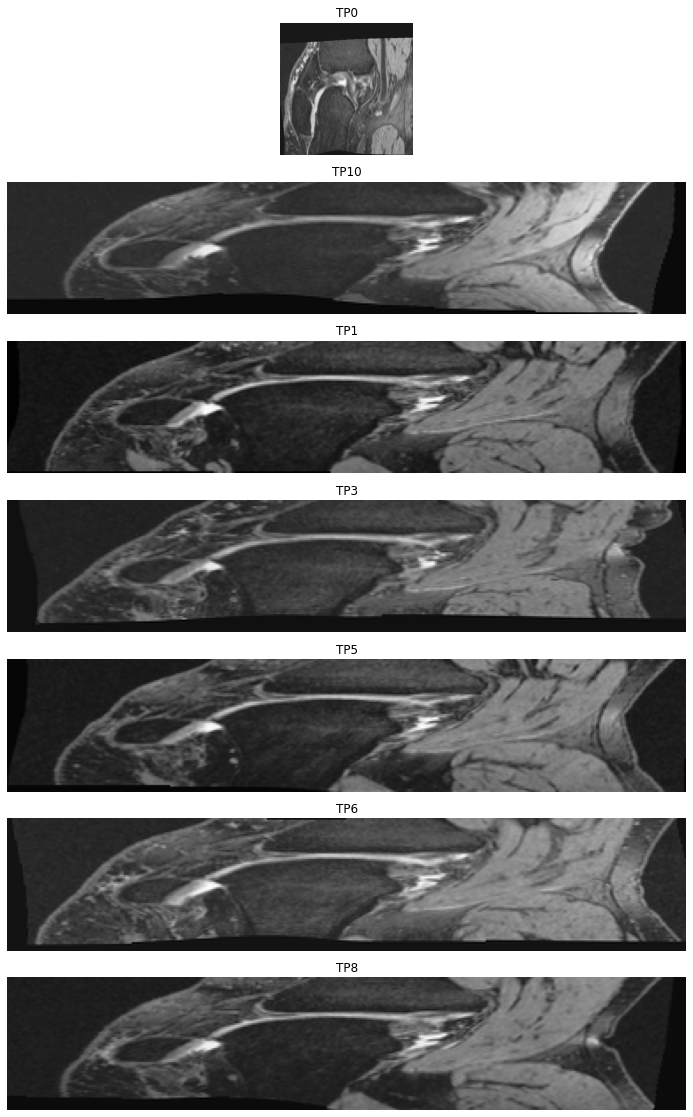

In [8]:
def show_registered_images(find_str): 
    path = 'C:\\Zhixuan\\OAI-registration\\pyKNEEr-yg\\registered\\'
    file_path_list = []
    for file in os.listdir(path):
        if find_str in file:
            file_path_list.append(file)
    i = 1
    # Create a figure with two subplots and the specified size.
    plt.subplots(len(file_path_list), 1,figsize=(25,20))
    for tmp_path in file_path_list:
        result_file_name              = path + tmp_path + '\\f_spline.mha'
#         mask_file_name                = image_data["segmented_folder"] + image_data[anatomy + "mask"]

        # read the images
        result = sitk.ReadImage(result_file_name)
#         mask   = sitk.ReadImage(mask_file_name)

        # images from simpleitk to numpy
    #     result_py = sitk.GetArrayFromImage(result)
    #         mask_py   = sitk.GetArrayFromImage(mask)
        pos1 = tmp_path.find('TP', 0)
        pos2 = tmp_path.find('_', pos1)
        tp = tmp_path[pos1:pos2]
        show_sagittal_images(result, len(file_path_list), i, tp)
        i = i + 1
    plt.show() 

show_registered_images('9941446R')

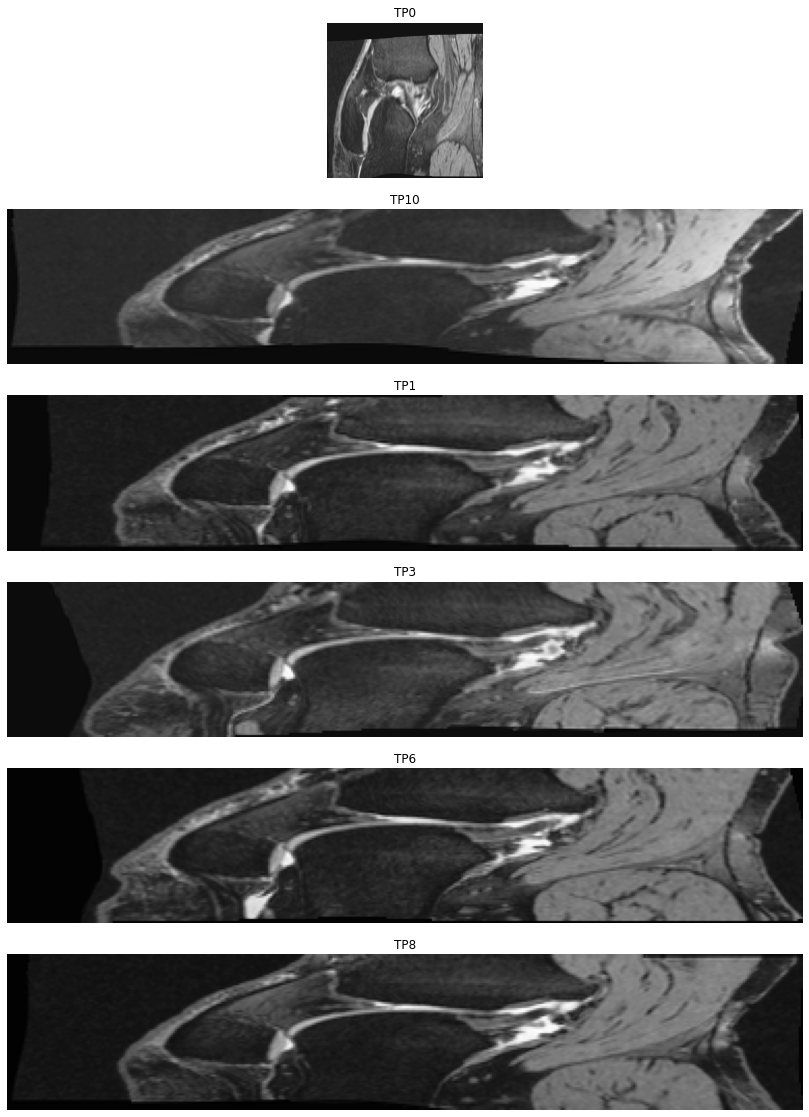

In [33]:
show_registered_images('9941446L')